How to make SVG without X11: http://matplotlib.org/faq/howto_faq.html#matplotlib-in-a-web-application-server

How to embed in django: make SVG, replace in template http://stackoverflow.com/questions/34958702/embedding-a-matplotlib-plot-within-a-django-site

Alternatively, make PNG and embed as base64


In [2]:
%qtconsole

In [61]:
import pickle
import matplotlib
matplotlib.use('Agg')
import pandas as pd
from IPython.display import SVG, display


In [62]:
pd=pickle.load(open("pd.pickle","rb"))

In [63]:
def get_pka_plot(prepData, pH=7.4, figSize=(8,12)):

    from matplotlib.pyplot import figure, cm
    from matplotlib.lines import Line2D
    import numpy as np
    
    acidicResidues = ['ASP','GLU','TYR']
    basicResidues = ['HIS','LYS','ARG']
    
    # titr =  (~ pd.isnull(d.pKa)) & d.pKa < 99
    d = prepData.data
    titr =  d.pKa < 99  # Automatically excludes NaN
    N = sum(titr)
    
    # Format residue labels
    labels = [x.resname+" "+str(x.resid)+x.insertion for i,x in d.loc[titr].iterrows()]
    pKas = d.pKa.loc[titr]
    restypes = ["neg" if x.resname in acidicResidues else "pos" for i,x in d.loc[titr].iterrows() ]
    

    # Shading
    C = 5
    X = np.array([range(C),range(C)])
    X = np.array([[1,1],[1,1]])
    # X = np.array([[1,1,1,1,1,1,1,0],[1,1,1,1,1,1,1,0]])

    xmin, xmax = xlim = 0, 14
    ymin, ymax = ylim = -1, N

    #fig = figure(figsize=figSize)
    fig = figure(figsize=figSize)
    ax = fig.add_subplot(111, xlim=xlim, ylim=ylim,
                         autoscale_on=False)
    ax.yaxis.set_ticks(range(N))
    ax.yaxis.set_ticklabels(labels)
    ax.invert_yaxis()

    width=.7
    for i in range(N):
        left=xmin
        right=xmax
        top=i+width/2
        bottom=i-width/2
        pk = pKas.iloc[i]
        restype = restypes[i]
        
        if restype == "neg":
            ax.imshow(X, 
                      cmap=cm.Blues, vmin=0, vmax=1,
                      extent=(pk, right, bottom, top), alpha=1)
            ax.text(xmax,i,"{:5.2f} ".format(pk),color="white", horizontalalignment="right")
        else:
            ax.imshow(X,
                      cmap=cm.Reds, vmin=0, vmax=1,
                      extent=(left, pk, bottom, top), alpha=1)
            ax.text(0,i,"{:5.2f} ".format(pk),color="white")

        # ax.add_line(Line2D([pk,pk], [bottom,top], linewidth=3, color='blue'))
        

    # Vertical line at pH
    ax.axvline(x=pH, linewidth=100, color="k", alpha=.2) 
    ax.axvline(x=pH, linewidth=20, color="k", alpha=.3) 

    ax.set_aspect('auto')
    
    # show()   # for interactive use
    from io import StringIO
    imgdata = StringIO()
    fig.savefig(imgdata, format="svg", bbox_inches='tight')
    return imgdata.getvalue()


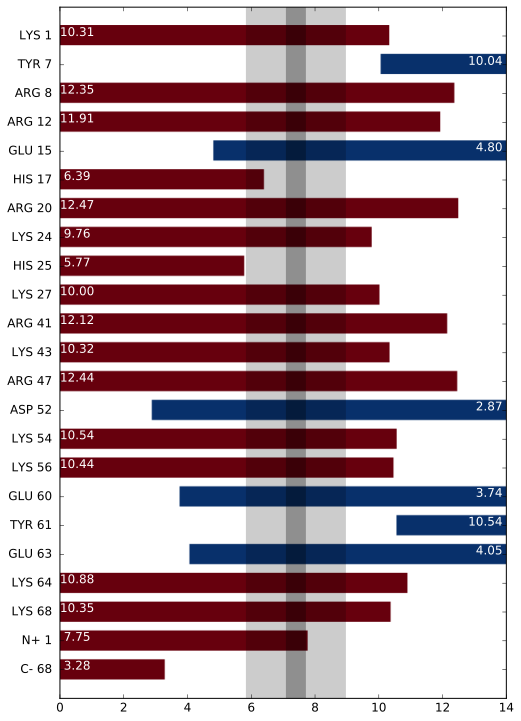

In [64]:
svg_plot=get_pka_plot(pd, pH=7.4)
display(SVG(svg_plot))

In [65]:
svg_plot[0:400]

'<?xml version="1.0" encoding="utf-8" standalone="no"?>\n<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"\n  "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">\n<!-- Created with matplotlib (http://matplotlib.org/) -->\n<svg height="721pt" version="1.1" viewBox="0 0 521 721" width="521pt" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink">\n <defs>\n  <style type="text/css">\n*{s'

In [66]:
?SVG
